## 딥러닝 실습 과제 3주차 - CNN을 활용한 이미지 데이터 증강 실험

다음  네 가지 활동을 해봅시다.

01. **데이터 전처리 및 로딩**: "기존" vs "기존 + 증강"
02. **모델 설계**: CNN 기반 분류 모델 재사용 및 수정
03. **손실 함수 정의**: 각 칸에 대해 3-클래스 분류
04. **증강 적용 유무에 따른 성능 비교**

TTTDataset.zip을 불러와 문제에서 요하는 코드를 구현하세요.

💡 **데이터 구조**  
- **`image_black`** : 이미지 데이터  
- **`labels`** : 타겟 데이터  

In [47]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import json
import glob
import os

import torch.nn as nn
import torch.optim as optim
from torchvision import datasets
import torch.nn.functional as F

## 00. 클래스
정의한 클래스를 이용해 실행해 주세요.

In [48]:
from google.colab import drive
drive.mount('/content/drive')

image_dir = '/content/drive/My Drive/KHS/TTTDataset/image_black'
label_dir = '/content/drive/My Drive/KHS/TTTDataset/labels'

image_paths = sorted(glob.glob(os.path.join(image_dir, "*.jpg")) +
                     glob.glob(os.path.join(image_dir, "*.JPG")))
label_paths = sorted(glob.glob(os.path.join(label_dir, "*.json")))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [49]:
class TTTDataset(Dataset):
    def __init__(self, image_paths, label_paths, transform=None):
        """
        틱택토 데이터셋을 PyTorch Dataset 형태로 변환.
        :param image_paths: 이미지 파일 경로 리스트
        :param label_paths: 레이블 JSON 파일 경로 리스트
        :param transform: 이미지 전처리 변환
        """
        self.image_paths = image_paths
        self.label_paths = label_paths
        self.transform = transform
        self.data = self._load_data()


    def _load_data(self):
        """ 이미지 & 레이블 로드 """
        data = []
        for img_path, lbl_path in zip(self.image_paths, self.label_paths):
            # 이미지를 흑백(Grayscale)로 변환
            image = Image.open(img_path).convert("L")  # "RGB" 대신 "L" 사용

            # JSON 레이블 로드
            with open(lbl_path, 'r') as f:
                labels = json.load(f)

            # 레이블을 숫자로 변환 (O=1, X=-1, blank=0)
            label_tensor = torch.tensor(
                [2 if v == "O" else 0 if v == "X" else 1 for v in labels.values()],
                dtype=torch.float32
            )
            data.append((image, label_tensor))

        return data


    def __len__(self):
        """ 데이터셋 크기 반환 """
        return len(self.data)


    def __getitem__(self, idx):
        """ 데이터셋에서 idx 번째 샘플(이미지 & 레이블)을 가져오는 역할 """
        image, label = self.data[idx]
        label = torch.tensor(label, dtype=torch.long)

        if self.transform:
            image = self.transform(image)

        return image, label

In [50]:
class TTTDataset(Dataset):
    def __init__(self, image_paths, label_paths, transform=None):
        """
        틱택토 데이터셋을 PyTorch Dataset 형태로 변환.
        :param image_paths: 이미지 파일 경로 리스트
        :param label_paths: 레이블 JSON 파일 경로 리스트
        :param transform: 이미지 전처리 변환
        """
        self.image_paths = image_paths
        self.label_paths = label_paths
        self.transform = transform
        self.data = self._load_data()


    def _load_data(self):
        """ 이미지 & 레이블 로드 """
        data = []
        for img_path, lbl_path in zip(self.image_paths, self.label_paths):
            # 이미지를 흑백(Grayscale)로 변환
            image = Image.open(img_path).convert("L")  # "RGB" 대신 "L" 사용

            # JSON 레이블 로드
            with open(lbl_path, 'r') as f:
                labels = json.load(f)

            # 레이블을 숫자로 변환 (O=1, X=-1, blank=0)
            label_tensor = torch.tensor(
                [2 if v == "O" else 0 if v == "X" else 1 for v in labels.values()],
                dtype=torch.float32
            )
            data.append((image, label_tensor))

        return data


    def __len__(self):
        """ 데이터셋 크기 반환 """
        return len(self.data)


    def __getitem__(self, idx):
        """ 데이터셋에서 idx 번째 샘플(이미지 & 레이블)을 가져오는 역할 """
        image, label = self.data[idx]
        label = torch.tensor(label, dtype=torch.long)

        if self.transform:
            image = self.transform(image)

        return image, label

## 01. 데이터 전처리 및 로딩: "기존" vs "기존 + 증강"

💡 실험을 위한 **두 개의 DataLoader**를 구성하세요 (1주차 과제 참고)
- 기존 데이터만 사용하는 DataLoader
- 기존 데이터 + 실시간 transform 증강을 적용한 DataLoader


In [51]:
from torchvision import transforms

In [52]:
# 기본 데이터셋 변형
transform = transforms.Compose([
    transforms.Resize((28, 28)),  # 이미지 크기를 28x28로 조정
    transforms.ToTensor(),  # 이미지를 PyTorch 텐서로 변환
    transforms.Normalize((0.5,), (0.5,))  # 정규화: 평균 0.5, 표준편차 0.5
])

# 증강 변환 설정 (기존 데이터 + 실시간 증강)
augmented_transform = transforms.Compose([
    transforms.Resize((28, 28)),  # 이미지 크기 조정
    transforms.RandomHorizontalFlip(),  # 랜덤으로 수평 뒤집기 (뒤집힐 확률 50%)
    transforms.RandomRotation(15),  # 랜덤 회전 (15도 max)
    transforms.ToTensor(),  # 이미지를 Tensor로 변환
    transforms.Normalize((0.5,), (0.5,))  # 정규화
])

# 기본 데이터셋 생성
dataset = TTTDataset(image_paths=image_paths, label_paths=label_paths, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# 증강 데이터셋 생성
dataset_augmented = TTTDataset(image_paths=image_paths, label_paths=label_paths, transform=augmented_transform)
dataloader_augmented = DataLoader(dataset_augmented, batch_size=32, shuffle=True)

## 02. 모델 설계: CNN 기반 분류 모델 재사용 및 수정
- 1채널 이미지 입력, 9 × 3-클래스 출력 구조 유지 (2주차 과제 참고)
- Dropout/Hidden Layer 등 수정 가능


In [53]:
class TicTacToeCNN(nn.Module):
    def __init__(self):
        super(TicTacToeCNN, self).__init__()

        # Convolutional Layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        # 1채널 이미지(흑백) 입력, 32 특징 맵 출력, 3*3 커널 필터, 패딩=1로 입력 사이즈 유지

        # Fully Connected Layers
        self.fc1 = nn.Linear(64 * 7 * 7, 128) # 128 뉴런으로 변환 출력
        self.fc2 = nn.Linear(128, 27)  # 9칸 * 3가지 상태 (O, X, blank)

    def forward(self, x):
        # Convolutional layers
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2) # 맥스 풀링 - 채널 수 유지, h, w의 공간 크기 변화
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)

        # Flatten - CNN에서 2차원 데이터를 다루므로 FcL 진입을 위해 평탄화 작업을 거쳐야 한다.
        x = x.view(x.size(0), -1)

        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        # Reshape to (batch_size, 9, 3)
        x = x.view(-1, 9, 3)

        # Apply softmax on each set of 3 outputs
        x = F.softmax(x, dim=2) # 각 클래스에 속할 확률 출력
        return x

model = TicTacToeCNN()

## 03. 손실 함수 정의: 각 칸에 대해 3-클래스 분류
- 다중 클래스 분류이므로 CrossEntropyLoss 사용 가능
- 9개 칸을 각각 분류하는 방식으로 모델 구성
- Adam 옵티마이저 사용 권장

In [54]:
# Cross-Entropy 손실 함수 선언
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Example optimizer

## 04. 증강 적용 유무에 따른 성능 비교
- 두 개의 DataLoader로 두 번 실험
- 같은 모델 구조로 학습 → 성능 차이 비교 (정확도/학습 안정성/과적합 여부 등)

In [55]:
num_epochs = 10
total_loss = 0
num_batches = 0

for epoch in range(num_epochs):
    total_loss = 0
    num_batches = 0
    for images, labels in dataloader:
        optimizer.zero_grad()  # Reset gradients

        outputs = model(images)  # Get model predictions
        outputs = outputs.view(-1, 3)

        # Flatten the labels if necessary
        labels = labels.view(-1)  # 예: (32, 9) -> (288,)

        # Compute loss
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        total_loss += loss.item()  # 손실값 누적
        num_batches += 1  # 배치 수 증가

        # 에포크마다 평균 손실 및 배치 수 출력
        average_loss = total_loss / num_batches  # 평균 손실 계산
        print(f'Epoch [{epoch + 1}/{num_epochs}], '
              f'Number of Batches: {num_batches}',
              f'Average Loss: {average_loss:.4f}, ')



<ipython-input-50-557ba86c7a60>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long)


Epoch [1/10], Number of Batches: 1 Average Loss: 1.0998, 
Epoch [1/10], Number of Batches: 2 Average Loss: 1.0992, 
Epoch [1/10], Number of Batches: 3 Average Loss: 1.0987, 
Epoch [1/10], Number of Batches: 4 Average Loss: 1.0954, 
Epoch [1/10], Number of Batches: 5 Average Loss: 1.0954, 
Epoch [1/10], Number of Batches: 6 Average Loss: 1.0932, 
Epoch [1/10], Number of Batches: 7 Average Loss: 1.0940, 
Epoch [1/10], Number of Batches: 8 Average Loss: 1.0936, 
Epoch [1/10], Number of Batches: 9 Average Loss: 1.0930, 
Epoch [1/10], Number of Batches: 10 Average Loss: 1.0928, 
Epoch [1/10], Number of Batches: 11 Average Loss: 1.0907, 
Epoch [1/10], Number of Batches: 12 Average Loss: 1.0906, 
Epoch [1/10], Number of Batches: 13 Average Loss: 1.0900, 
Epoch [1/10], Number of Batches: 14 Average Loss: 1.0898, 
Epoch [1/10], Number of Batches: 15 Average Loss: 1.0890, 
Epoch [2/10], Number of Batches: 1 Average Loss: 1.0727, 
Epoch [2/10], Number of Batches: 2 Average Loss: 1.0704, 
Epoch [2

In [56]:
num_epochs = 10
total_loss = 0
num_batches = 0

for epoch in range(num_epochs):
    total_loss = 0
    num_batches = 0
    for images, labels in dataloader_augmented:
        optimizer.zero_grad()  # Reset gradients

        outputs = model(images)  # Get model predictions
        outputs = outputs.view(-1, 3)

        # Flatten the labels if necessary
        labels = labels.view(-1)  # 예: (32, 9) -> (288,)

        # Compute loss
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        total_loss += loss.item()  # 손실값 누적
        num_batches += 1  # 배치 수 증가

        # 에포크마다 평균 손실 및 배치 수 출력
        average_loss = total_loss / num_batches  # 평균 손실 계산
        print(f'Epoch [{epoch + 1}/{num_epochs}], '
              f'Number of Batches: {num_batches}',
              f'Average Loss: {average_loss:.4f}, ')



<ipython-input-50-557ba86c7a60>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long)


Epoch [1/10], Number of Batches: 1 Average Loss: 0.8793, 
Epoch [1/10], Number of Batches: 2 Average Loss: 0.9202, 
Epoch [1/10], Number of Batches: 3 Average Loss: 0.9261, 
Epoch [1/10], Number of Batches: 4 Average Loss: 0.9371, 
Epoch [1/10], Number of Batches: 5 Average Loss: 0.9312, 
Epoch [1/10], Number of Batches: 6 Average Loss: 0.9360, 
Epoch [1/10], Number of Batches: 7 Average Loss: 0.9351, 
Epoch [1/10], Number of Batches: 8 Average Loss: 0.9323, 
Epoch [1/10], Number of Batches: 9 Average Loss: 0.9331, 
Epoch [1/10], Number of Batches: 10 Average Loss: 0.9327, 
Epoch [1/10], Number of Batches: 11 Average Loss: 0.9319, 
Epoch [1/10], Number of Batches: 12 Average Loss: 0.9322, 
Epoch [1/10], Number of Batches: 13 Average Loss: 0.9291, 
Epoch [1/10], Number of Batches: 14 Average Loss: 0.9303, 
Epoch [1/10], Number of Batches: 15 Average Loss: 0.9235, 
Epoch [2/10], Number of Batches: 1 Average Loss: 0.8825, 
Epoch [2/10], Number of Batches: 2 Average Loss: 0.9109, 
Epoch [2

In [57]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [60]:
def plot_confusion_matrix(y_true, y_pred, classes):
    """ 혼동 행렬을 시각화하는 함수 """
    cm = confusion_matrix(y_true, y_pred)  # 혼동 행렬 계산
    plt.figure(figsize=(8, 6))

    # 혼동 행렬을 히트맵으로 시각화
    sns.heatmap(cm, annot=True, fmt='d', cmap='berlin',
                xticklabels=classes, yticklabels=classes)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()

def evaluate_model(model, dataloader):
    model.eval()  # 모델을 평가 모드로 설정
    all_preds = []  # 예측을 저장할 리스트
    all_labels = []  # 실제 레이블을 저장할 리스트

    with torch.no_grad():  # 그래디언트 계산 비활성화
        for images, labels in dataloader:
            outputs = model(images)  # 예측 수행
            outputs = outputs.view(-1, 3)  # 필요에 따라 형태 변환
            _, predicted = torch.max(outputs, 1)  # 가장 높은 확률 클래스 선택

            all_preds.extend(predicted.numpy())  # 예측값 저장
            all_labels.extend(labels.view(-1).numpy())  # 실제 레이블 저장

    return all_labels, all_preds  # 실제 레이블 및 예측값 반환

<ipython-input-50-557ba86c7a60>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long)


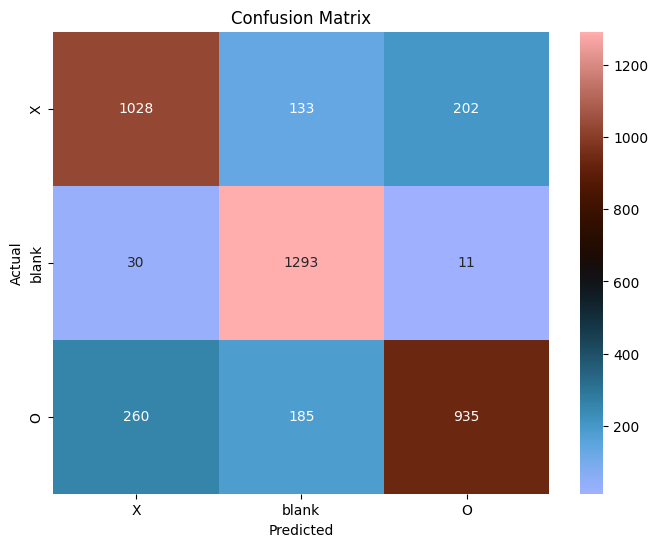

In [61]:
all_labels, all_preds = evaluate_model(model, dataloader)
class_names = ['X', 'blank', 'O'] # 클래스 이름 정의
plot_confusion_matrix(all_labels, all_preds, classes=class_names) # 혼돈 행렬로 시각화

<ipython-input-50-557ba86c7a60>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long)


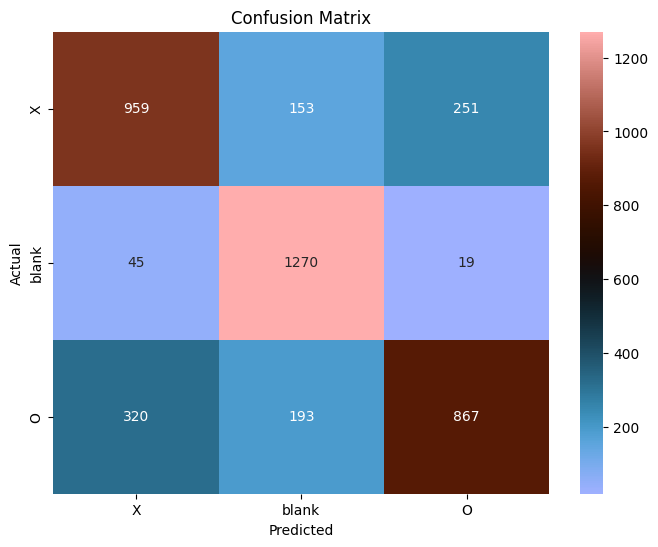

In [62]:
all_labels, all_preds = evaluate_model(model, dataloader_augmented)
class_names = ['X', 'blank', 'O'] # 클래스 이름 정의
plot_confusion_matrix(all_labels, all_preds, classes=class_names) # 혼돈 행렬로 시각화